In [1]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

Read all relevant data files and merge into one complete data file.

In [33]:
# Import the main data set
data = pd.read_pickle('df_LA_parcels_LAcity_cleaned_REV3_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000] # Set price to under 2 million. Too generalized if all home prices included.
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier (only 1 data point)
data = data[data['LandBaseYear'] >= 2015] # Remove homes that have not been sold in a very long time, data is likely inaccurate
data.shape[0] # Check number of data points remaining

87496

In [3]:
# Import the number of crimes committed in each neighborhood from 2010 to 2019
crime_data = pd.read_csv('neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')

In [4]:
# Import the custom clustering from the EDA section of this project.
# Clustered based on geographical area and median TotalValue to distinguish between rich and poor neighborhoods
neighborhood_cluster_data = pd.read_pickle('neighborhoods_cluster.pkl')
neighborhood_cluster_data['cluster'] = neighborhood_cluster_data['cluster'].astype(int) # Convert from object to int
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')

In [5]:
# Import the number of times a home has been sold in the past 15 years
sold_frequency_data = pd.read_pickle('df_LAcity_parcels_numberSold.pkl')
data = data.merge(sold_frequency_data, on = 'AIN')

Drop irrelevant columns.

In [6]:
data = data.drop(columns = ['AIN', 'Cluster', 'ZIPcode5', 'ZIPcode4', 'geometry'])
data.head()

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,...,C_score,BI_score,ID_score,Wd_score,LL_score,ShapeSTAre,ShapeSTLen,crime_count,cluster,NumberSold
0,2529.0,5,3,478659.0,2015,880822.0,1964,1964,0101,16,...,1,1,1,1,1,11926.526367,439.249106,5010,4,1
1,2776.0,5,5,467980.0,2019,927509.0,1979,1985,0101,16,...,1,1,1,1,1,7509.874023,364.494869,5010,4,2
2,1875.0,4,2,527135.0,2019,788383.0,1963,1963,0101,16,...,2,2,1,1,1,11025.290039,428.316700,5010,4,1
3,2414.0,4,3,522291.0,2019,772924.0,1976,1976,0101,16,...,1,1,1,1,1,8343.906250,396.337344,5010,4,1
4,1303.0,3,2,411484.0,2015,558488.0,1961,1961,0100,16,...,1,1,1,1,1,7525.905273,359.202499,5010,4,2


Correlation between each of the current features of the data set.

In [7]:
correlation = data.corr()

<AxesSubplot:>

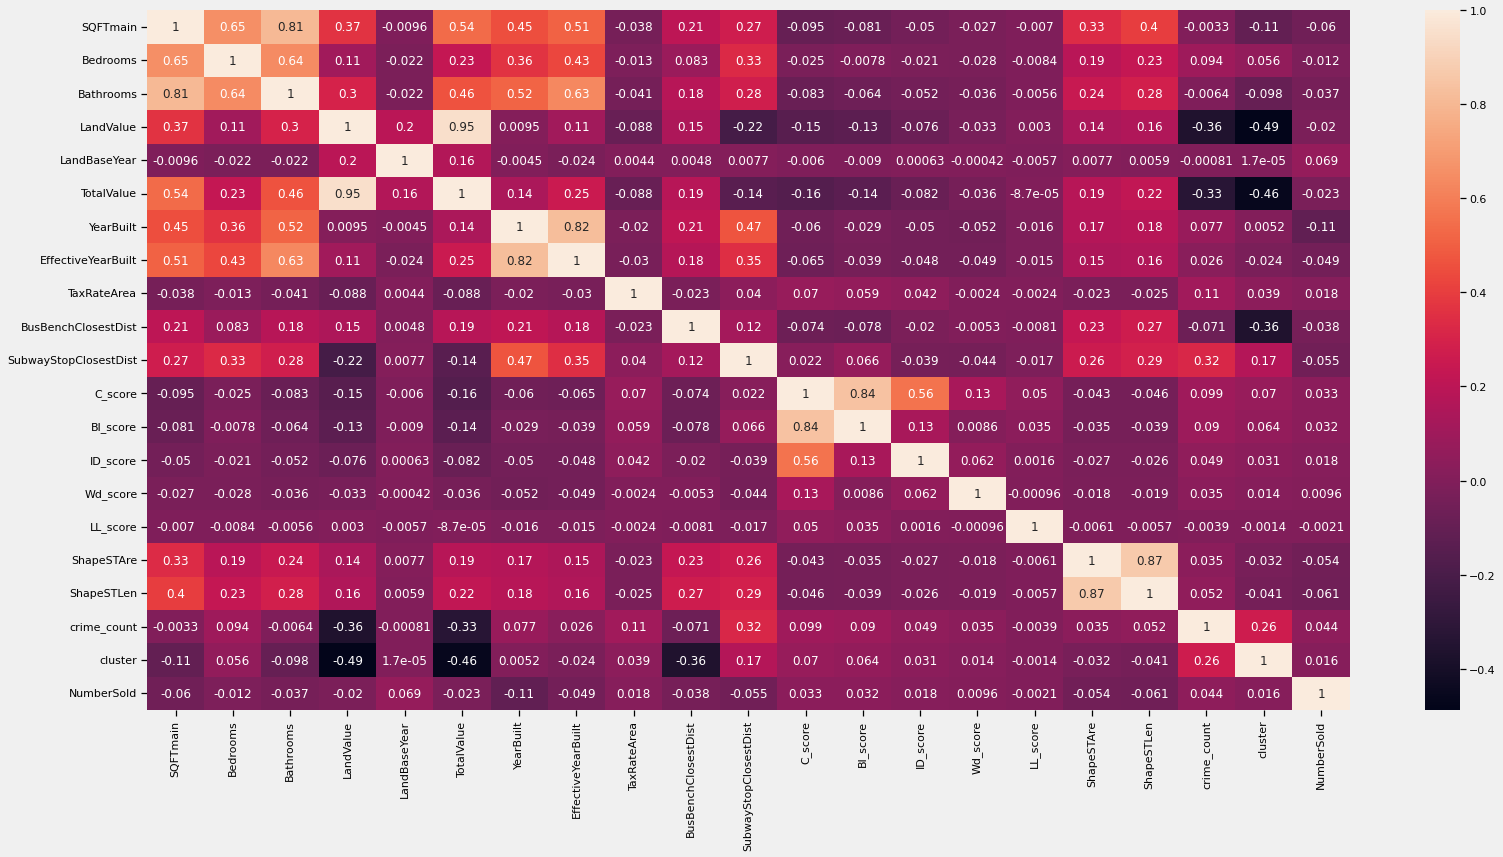

In [8]:
plt.figure(figsize = (24, 12))
sns.heatmap(correlation, annot=True)

Look at the info of each column in the data set.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87496 entries, 0 to 87495
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SQFTmain               87496 non-null  float64
 1   Bedrooms               87496 non-null  int64  
 2   Bathrooms              87496 non-null  int64  
 3   LandValue              87496 non-null  float64
 4   LandBaseYear           87496 non-null  int64  
 5   TotalValue             87496 non-null  float64
 6   YearBuilt              87496 non-null  int64  
 7   EffectiveYearBuilt     87496 non-null  int64  
 8   PropertyUseCode        87496 non-null  object 
 9   TaxRateArea            87496 non-null  int64  
 10  BusBenchClosestDist    87496 non-null  float64
 11  SubwayStopClosestDist  87496 non-null  float64
 12  Neighborhood           87496 non-null  object 
 13  C_score                87496 non-null  int64  
 14  BI_score               87496 non-null  int64  
 15  ID

In [10]:
data.isnull().sum()

SQFTmain                 0
Bedrooms                 0
Bathrooms                0
LandValue                0
LandBaseYear             0
TotalValue               0
YearBuilt                0
EffectiveYearBuilt       0
PropertyUseCode          0
TaxRateArea              0
BusBenchClosestDist      0
SubwayStopClosestDist    0
Neighborhood             0
C_score                  0
BI_score                 0
ID_score                 0
Wd_score                 0
LL_score                 0
ShapeSTAre               0
ShapeSTLen               0
crime_count              0
cluster                  0
NumberSold               0
dtype: int64

Label the data into groups based on TotalValue, split into 4 groups. This is for stratifying the dataset when splitting into train, test, val sets so that the data split is balanced. This can also be used as a feature, people typically know ballpark ranges of prices of each home if they are shopping for/selling real estate, binning into quartiles seems to be reasonable and perhaps even on the conservative side.

In [11]:
# Group the data into Quartiles based on TotalValue for stratifying purposes
data['Quartile_Number'] = 0

data.loc[
    (data['TotalValue'] >= 0) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.25)), 
    'Quartile_Number'] = 1

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.25)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.5)), 
    'Quartile_Number'] = 2

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.5)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 3

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 4

data['TotalValue'].quantile([0.25, 0.5, 0.75])

0.25    535490.0
0.50    698836.5
0.75    985100.0
Name: TotalValue, dtype: float64

Split the data into training set, validation set, and test set.

In [12]:
train, evaluate = train_test_split(data, test_size = 0.3, random_state = 0, stratify = data['Quartile_Number'])
val, test = train_test_split(evaluate, test_size = 0.5, random_state = 0, stratify = evaluate['Quartile_Number'])

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.99977141812197%
Val 14.999542836243943%
Test 15.000685745634085%


## Feature Engineering

Keep a list of thoughts of each feature and what to do with each feature <br>

Feature: <br>

AIN: No application. <br>

SQFTmain: Directly into Linear Regression Model. <br>

Bedrooms: Directly into Linear Regression Model. <br>

Bathrooms: Directly into Linear Regression Model. <br>

LandValue: Target leakage, people usually do not have this specific data in RE industry. However, this can be used to feature engineer a more generalized form to include in the ML model. <br>

LandBaseYear: Defines how recently a home was sold. Directly into Linear Regression Model. <br>

TotalValue: This is the target. <br>

YearBuilt: Redundant with effective year built, and a more generalized version. Probably not needed. <br>

EffectiveYearBuilt: Directly into Linear Regression Model. <br>

PropertyUseCode: One-hot-encode to distinguish between pool, no pool, etc. <br>

TaxRateArea: One-hot-encode to distinguish tax areas. Curse of dimensionality? <br>

Cluster: Bad correlation with total value, so probably not useful in the ML model. <br>

Zipcode5: No apparent correlation with TotalValue, might not be useful to predicting home prices. <br>

Zipcode4: Similar to zipcode5, but even worse because there are null values present. <br>

BusBenchClosestDist: Directly into Linear Regression Model. <br>

SubwayStopClosestDist: May not be the best indicator of home prices because subways can be quite loud to live near, so the convenience vs. noise may conflict with each other. Also must consider the quality of the subways in California, this would probably be a more useful feature in New York. <br>

Neighborhood: Can be used to do a lot of feature engineering. <br>

C_score: Cleanliness score. Low correlation with TotalValue, probably not needed. <br>

BI_score: Bulky-Items score. Low correlation with TotalValue, probably not needed. <br>

ID_score: Illegal Dumping score. Low correlation with TotalValue, probably not needed. <br>

Wd_score: Weeds score. Low correlation with TotalValue, probably not needed. <br>

LL_score: Litter score. Low correlation with TotalValue, probably not needed. <br>

ShapeSTAre: Directly into Linear Regression Model. <br>

ShapeSTLen: It seems redundant to include with ShapeSTAre. Try including it and see if the model improves. <br>

crime_count: Ok correlation, test the model with and without the feature and see if it improves the model. <br>

cluster: Distinguishes rich and poor areas. Directly into Linear Regression Model. <br>

NumberSold: Determines number of times a home has been sold in the past 15 years. Directly into Linear Regression Model. <br>

In [13]:
# Find relevant median values (by neighborhood and land base year) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'LandBaseYear', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'TotalValue', 'LandValue']]
    .groupby(['Neighborhood', 'LandBaseYear']).median()
)
neighborhood_medians

YearBuilt  EffectiveYearBuilt  SQFTmain  \
Neighborhood    LandBaseYear                                            
Adams-Normandie 2015             1906.0              1912.0    2025.0   
                2016             1908.0              1909.0    1440.0   
                2017             1907.0              1925.0    1859.5   
                2018             1905.5              1910.0    2087.0   
                2019             1907.0              1917.5    1733.0   
...                                 ...                 ...       ...   
Woodland Hills  2017             1960.0              1965.0    2163.5   
                2018             1960.0              1965.0    2128.5   
                2019             1960.0              1964.0    2116.5   
                2020             1960.0              1964.0    2235.0   
                2021             1960.0              1963.0    2111.5   

                              TotalValue  LandValue  
Neighborhood    LandBaseYear                         
Adams-Normandie 2015            518263.0   355302.0  
                2016            514010.0   393711.0  
                2017            743034.0   534599.0  
                2018            814662.5   627184.5  
                2019            700269.0   545787.5  
...                                  ...        ...  
Woodland Hills  2017            841675.0   572340.0  
                2018            880791.0   606161.0  
                2019            897787.5   625863.0  
                2020            940644.0   654713.0  
                2021            972500.0   684800.0  

[771 rows x 5 columns]

In [14]:
neighborhood_medians.corr()

,YearBuilt,EffectiveYearBuilt,SQFTmain,TotalValue,LandValue
YearBuilt,1.000000,0.933392,0.276055,0.116673,0.065992
EffectiveYearBuilt,0.933392,1.000000,0.304621,0.186499,0.129561
SQFTmain,0.276055,0.304621,1.000000,0.555460,0.503802
TotalValue,0.116673,0.186499,0.555460,1.000000,0.992719
LandValue,0.065992,0.129561,0.503802,0.992719,1.000000


Since Real Estate prices are very dependent on its neighbors, these median values can be a useful representation of the overall condition of the neighborhood. Add median total value, land value, year built, effective year built, and sqft main to the data set. Median total value and land value are not considered data leakage because it is only performed on the training set, and people typically know a ballpark figure out how much a house should cost per neighborhood.

In [15]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'TotalValue', 'LandValue']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(train)

In [16]:
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,...,ShapeSTLen,crime_count,cluster,NumberSold,Quartile_Number,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,TotalValue_median,LandValue_median
0,1347.0,3,2,452006.0,2018,609682.0,1922,1958,0100,212,...,350.865218,7860,4,3,2,1924.0,1933.0,1326.0,545593.0,410117.0
1,1098.0,2,1,314093.0,2016,392615.0,1922,1925,0100,212,...,363.709504,7860,4,2,1,1924.0,1933.0,1326.0,545593.0,410117.0
2,1125.0,2,1,476000.0,2021,595000.0,1915,1927,0100,212,...,345.611712,7860,4,2,2,1924.0,1933.0,1326.0,545593.0,410117.0
3,1126.0,3,2,315353.0,2018,420470.0,1924,1928,0100,212,...,360.023667,7860,4,2,1,1924.0,1933.0,1326.0,545593.0,410117.0
4,1950.0,4,2,791537.0,2018,917678.0,1923,1928,0100,212,...,380.056142,7860,4,2,3,1924.0,1933.0,1326.0,545593.0,410117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61242,916.0,2,1,619556.0,2015,741689.0,1916,1920,0100,13,...,398.014324,129,4,0,3,1922.0,1929.5,1171.0,573220.5,414833.0
61243,1132.0,3,1,245842.0,2017,385619.0,1900,1900,0100,6658,...,264.574633,1777,4,1,1,1900.0,1900.0,1132.0,385619.0,245842.0
61244,1628.0,3,2,433489.0,2017,648679.0,1963,1963,0100,13,...,445.159777,97,4,2,2,1961.0,1979.0,1648.0,685037.5,422857.5
61245,1668.0,3,2,412226.0,2019,721396.0,1959,1995,0100,13,...,848.693375,97,4,1,3,1961.0,1979.0,1648.0,685037.5,422857.5


Take a look at the relationship between SQFTmain, TotalValue and Neighborhood.

<function matplotlib.pyplot.show(close=None, block=None)>

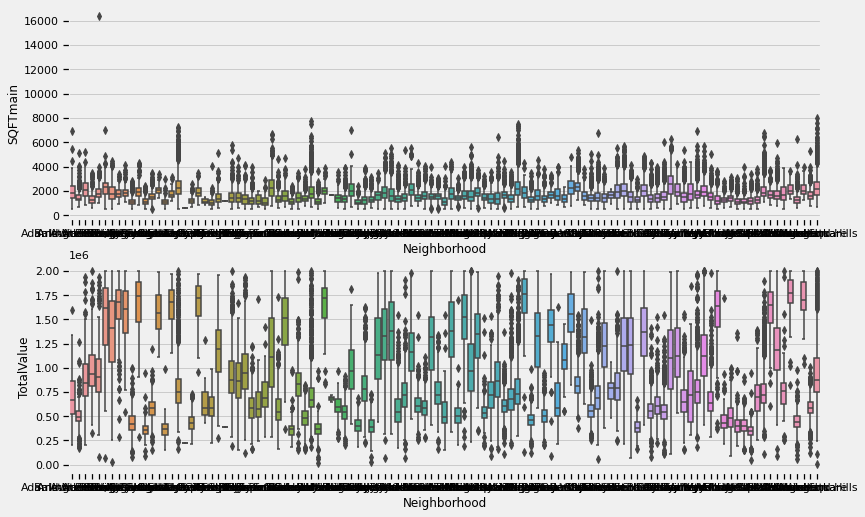

In [17]:
# Find a feature that can help distinguish between richer and "poorer" neighborhoods
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

sns.boxplot(x='Neighborhood', y='SQFTmain', data=train.sort_values('Neighborhood'), ax=axs[0])
sns.boxplot(x='Neighborhood', y='TotalValue', data=train.sort_values('Neighborhood'), ax=axs[1])
plt.show

Find rich and poor neighborhoods.

In [18]:
def find_rich_neighborhoods(data, n = 10, metric=np.median):
    """
    Find wealthy neighborhoods based on the median TotalValue of a residential property.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'TotalValue']]                # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
        .sort_values(by = 'TotalValue', ascending = False)  # Sort values by descending sale price
        .iloc[:n]                                           # Find the top n number of most expensive neighborhoods
        .index.to_list()                                    # Create a list of the names of the top most expensive neighborhoods
    )
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train)

# Print rich neighborhoods
print('The rich neighborhoods are: {}'.format(rich_neighborhoods))

The rich neighborhoods are: ['Westwood', 'Pacific Palisades', 'Brentwood', 'Hancock Park', 'Cheviot Hills', 'Windsor Square', 'Beverly Grove', 'Century City', 'West Los Angeles', 'Venice']


In [19]:
def find_poor_neighborhoods(data, n = 10, metric=np.median):
    """
    Find poor neighborhoods based on the median TotalValue of a residential property.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'TotalValue']]                # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
        .sort_values(by = 'TotalValue')                     # Sort values by ascending sale price
        .iloc[:n]                                           # Find the top n number of most expensive neighborhoods
        .index.to_list()                                    # Create a list of the names of the top most expensive neighborhoods
    )
    
    return neighborhoods

# Find poor neighborhoods
poor_neighborhoods = find_poor_neighborhoods(train)

# Print poor neighborhoods
print('The poor neighborhoods are: {}'.format(poor_neighborhoods))

The poor neighborhoods are: ['Chatsworth Reservoir', 'Watts', 'Broadway-Manchester', 'Green Meadows', 'Florence', 'Central-Alameda', 'South Park', 'Downtown', 'Historic South-Central', 'Vermont-Slauson']


In [20]:
def add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood'
      rich_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
      poor_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as poor
    Output:
      data frame identical to the input with the addition of two binary
      in_rich_neighborhood and in_poor_neighborhood columns
    """
    data_copy = data.copy()
    
    # Write your code here.
    data_copy['in_rich_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(rich_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    data_copy['in_poor_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(poor_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    return data_copy

# Add 'in_rich_neighborhood' feature
training_data = add_in_neighborhoods(training_data, rich_neighborhoods, poor_neighborhoods)

# View DataFrame
training_data.head()

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,...,cluster,NumberSold,Quartile_Number,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,TotalValue_median,LandValue_median,in_rich_neighborhood,in_poor_neighborhood
0,1347.0,3,2,452006.0,2018,609682.0,1922,1958,0100,212,...,4,3,2,1924.0,1933.0,1326.0,545593.0,410117.0,0,0
1,1098.0,2,1,314093.0,2016,392615.0,1922,1925,0100,212,...,4,2,1,1924.0,1933.0,1326.0,545593.0,410117.0,0,0
2,1125.0,2,1,476000.0,2021,595000.0,1915,1927,0100,212,...,4,2,2,1924.0,1933.0,1326.0,545593.0,410117.0,0,0
3,1126.0,3,2,315353.0,2018,420470.0,1924,1928,0100,212,...,4,2,1,1924.0,1933.0,1326.0,545593.0,410117.0,0,0
4,1950.0,4,2,791537.0,2018,917678.0,1923,1928,0100,212,...,4,2,3,1924.0,1933.0,1326.0,545593.0,410117.0,0,0


Before One Hot Encoding, see the correlation matrix of the current potential features

<AxesSubplot:>

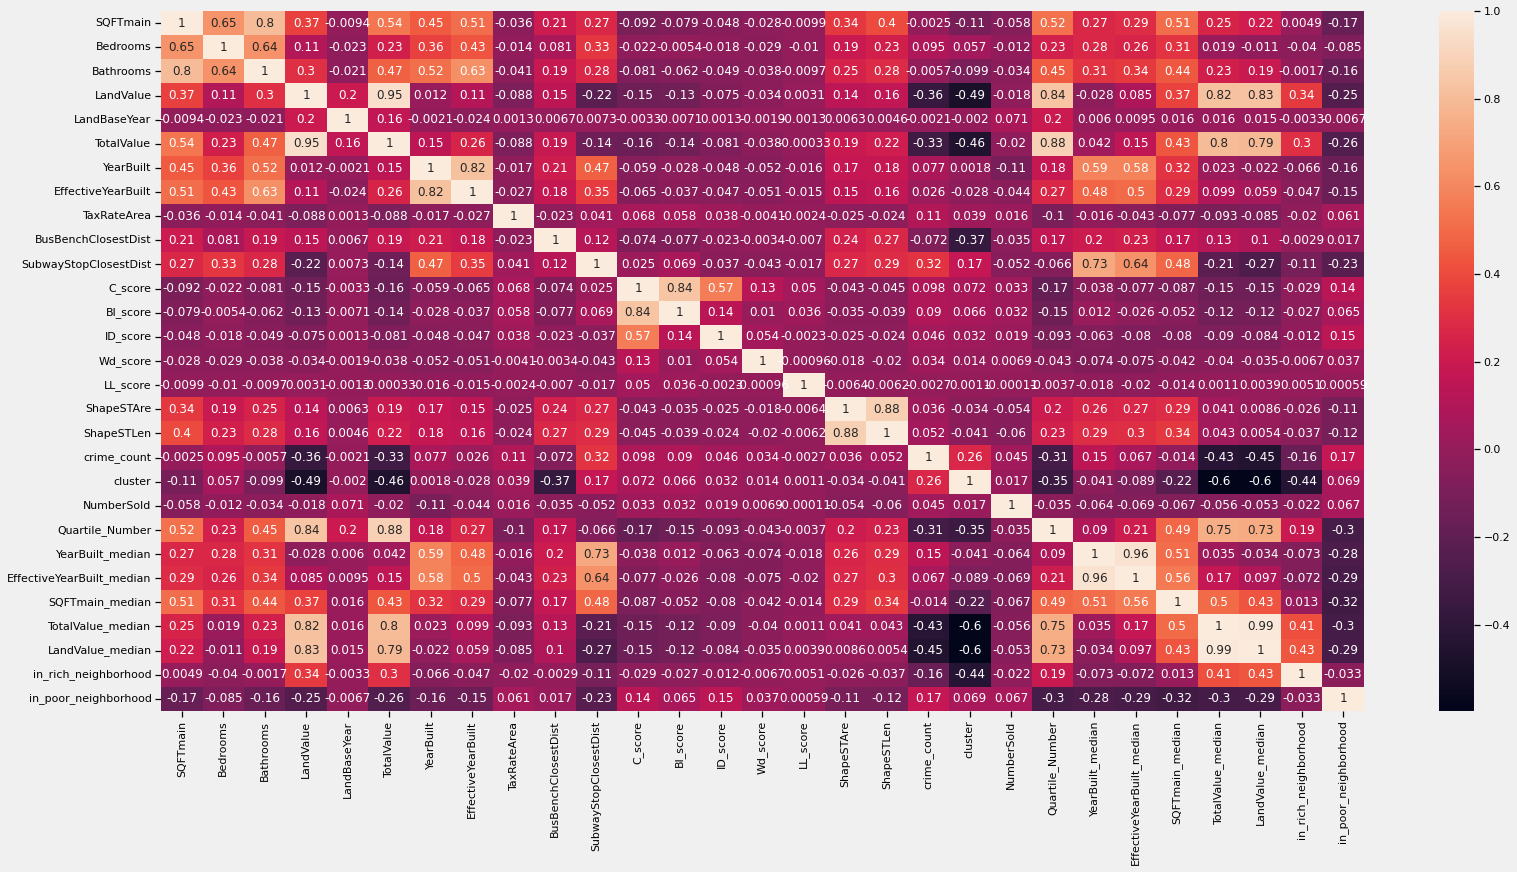

In [21]:
plt.figure(figsize = (24, 12))
sns.heatmap(training_data.corr(), annot=True)

<br>
One hot encode the property use code to distinguish between homes with pools, without pools, etc.

In [22]:
def ohe_pusecode(data):
    """
    One-hot-encodes Property Use Code.
    New columns are of the form PropertyUseCode_CODE
    """
    # List categories
    categories = ['0100', # No Pool
                  '0101', # Pool
                  '0103', # Pool and misc.
                  '0104', # Therapy Pool
                  ]

    category_type = pd.CategoricalDtype(categories=categories)
    data['PropertyUseCode'] = data['PropertyUseCode'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='PropertyUseCode',
                          columns=['PropertyUseCode'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_pusecode(training_data)
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,BusBenchClosestDist,...,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,TotalValue_median,LandValue_median,in_rich_neighborhood,in_poor_neighborhood,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104
0,1347.0,3,2,452006.0,2018,609682.0,1922,1958,212,1145.533532,...,1924.0,1933.0,1326.0,545593.0,410117.0,0,0,0,0,0
1,1098.0,2,1,314093.0,2016,392615.0,1922,1925,212,731.331076,...,1924.0,1933.0,1326.0,545593.0,410117.0,0,0,0,0,0
2,1125.0,2,1,476000.0,2021,595000.0,1915,1927,212,1629.191824,...,1924.0,1933.0,1326.0,545593.0,410117.0,0,0,0,0,0
3,1126.0,3,2,315353.0,2018,420470.0,1924,1928,212,298.632940,...,1924.0,1933.0,1326.0,545593.0,410117.0,0,0,0,0,0
4,1950.0,4,2,791537.0,2018,917678.0,1923,1928,212,867.422902,...,1924.0,1933.0,1326.0,545593.0,410117.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61242,916.0,2,1,619556.0,2015,741689.0,1916,1920,13,2931.171547,...,1922.0,1929.5,1171.0,573220.5,414833.0,0,0,0,0,0
61243,1132.0,3,1,245842.0,2017,385619.0,1900,1900,6658,874.560981,...,1900.0,1900.0,1132.0,385619.0,245842.0,0,1,0,0,0
61244,1628.0,3,2,433489.0,2017,648679.0,1963,1963,13,5338.731636,...,1961.0,1979.0,1648.0,685037.5,422857.5,0,0,0,0,0
61245,1668.0,3,2,412226.0,2019,721396.0,1959,1995,13,6065.995675,...,1961.0,1979.0,1648.0,685037.5,422857.5,0,0,0,0,0


One hot encode the TaxRateArea

In [23]:
taxrate_categories = data['TaxRateArea'].unique()

def ohe_taxratearea(data):
    """
    One-hot-encodes Tax Rate Area.
    New columns are of the form TaxRateArea_AREA
    """
    # List categories
    categories = taxrate_categories

    category_type = pd.CategoricalDtype(categories=categories)
    data['TaxRateArea'] = data['TaxRateArea'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='TaxRateArea',
                          columns=['TaxRateArea'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_taxratearea(training_data)
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,BusBenchClosestDist,SubwayStopClosestDist,...,TaxRateArea_400,TaxRateArea_18,TaxRateArea_13245,TaxRateArea_21,TaxRateArea_482,TaxRateArea_308,TaxRateArea_20,TaxRateArea_497,TaxRateArea_470,TaxRateArea_13811
0,1347.0,3,2,452006.0,2018,609682.0,1922,1958,1145.533532,12843.371105,...,0,0,0,0,0,0,0,0,0,0
1,1098.0,2,1,314093.0,2016,392615.0,1922,1925,731.331076,13098.755967,...,0,0,0,0,0,0,0,0,0,0
2,1125.0,2,1,476000.0,2021,595000.0,1915,1927,1629.191824,7582.184571,...,0,0,0,0,0,0,0,0,0,0
3,1126.0,3,2,315353.0,2018,420470.0,1924,1928,298.632940,16487.704994,...,0,0,0,0,0,0,0,0,0,0
4,1950.0,4,2,791537.0,2018,917678.0,1923,1928,867.422902,10551.124281,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61242,916.0,2,1,619556.0,2015,741689.0,1916,1920,2931.171547,4014.480726,...,0,0,0,0,0,0,0,0,0,0
61243,1132.0,3,1,245842.0,2017,385619.0,1900,1900,874.560981,456.920058,...,0,0,0,0,0,0,0,0,0,0
61244,1628.0,3,2,433489.0,2017,648679.0,1963,1963,5338.731636,38122.088048,...,0,0,0,0,0,0,0,0,0,0
61245,1668.0,3,2,412226.0,2019,721396.0,1959,1995,6065.995675,38016.317149,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [25]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61247 entries, 0 to 61246
Columns: 122 entries, SQFTmain to TaxRateArea_13811
dtypes: float64(12), int32(3), int64(13), object(1), uint8(93)
memory usage: 18.7+ MB


In [26]:
def process_data(data):
    """Combine all pipelines to create processed data."""
    # One-hot-encode PropertyUseCode feature
    data = ohe_pusecode(data)
    
    # One-hot-encode TaxRateArea feature
    data = ohe_taxratearea(data)
    
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Add in the rich and poor neighborhoods
    data = add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'LandValue_median',
                         'TotalValue_median',
                         'Quartile_Number',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'cluster',
                         'NumberSold'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

In [27]:
# Copy of all features considered for use
training_data.columns.to_list()

['SQFTmain',
 'Bedrooms',
 'Bathrooms',
 'LandValue',
 'LandBaseYear',
 'TotalValue',
 'YearBuilt',
 'EffectiveYearBuilt',
 'BusBenchClosestDist',
 'SubwayStopClosestDist',
 'Neighborhood',
 'C_score',
 'BI_score',
 'ID_score',
 'Wd_score',
 'LL_score',
 'ShapeSTAre',
 'ShapeSTLen',
 'crime_count',
 'cluster',
 'NumberSold',
 'Quartile_Number',
 'YearBuilt_median',
 'EffectiveYearBuilt_median',
 'SQFTmain_median',
 'TotalValue_median',
 'LandValue_median',
 'in_rich_neighborhood',
 'in_poor_neighborhood',
 'PropertyUseCode_0101',
 'PropertyUseCode_0103',
 'PropertyUseCode_0104',
 'TaxRateArea_51',
 'TaxRateArea_13257',
 'TaxRateArea_13261',
 'TaxRateArea_408',
 'TaxRateArea_13766',
 'TaxRateArea_13765',
 'TaxRateArea_13764',
 'TaxRateArea_13767',
 'TaxRateArea_8852',
 'TaxRateArea_37',
 'TaxRateArea_65',
 'TaxRateArea_2318',
 'TaxRateArea_13',
 'TaxRateArea_8859',
 'TaxRateArea_8856',
 'TaxRateArea_8849',
 'TaxRateArea_8831',
 'TaxRateArea_42',
 'TaxRateArea_67',
 'TaxRateArea_1723',
 

In [28]:
X_train, y_train = process_data(train)
    
X_train.head()

,SQFTmain,Bedrooms,Bathrooms,LandBaseYear,EffectiveYearBuilt,ShapeSTAre,ShapeSTLen,crime_count,PropertyUseCode_0101,PropertyUseCode_0103,...,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,LandValue_median,TotalValue_median,Quartile_Number,in_rich_neighborhood,in_poor_neighborhood,cluster,NumberSold
0,1347.0,3,2,2018,1958,5416.727539,350.865218,7860,0,0,...,1924.0,1933.0,1326.0,410117.0,545593.0,2,0,0,4,3
1,1098.0,2,1,2016,1925,6248.902344,363.709504,7860,0,0,...,1924.0,1933.0,1326.0,410117.0,545593.0,1,0,0,4,2
2,1125.0,2,1,2021,1927,6140.591797,345.611712,7860,0,0,...,1924.0,1933.0,1326.0,410117.0,545593.0,2,0,0,4,2
3,1126.0,3,2,2018,1928,6075.338867,360.023667,7860,0,0,...,1924.0,1933.0,1326.0,410117.0,545593.0,1,0,0,4,2
4,1950.0,4,2,2018,1928,7001.445312,380.056142,7860,0,0,...,1924.0,1933.0,1326.0,410117.0,545593.0,3,0,0,4,2


## Create Linear Regression Model

Create a cross-validation function returning the root mse from all splits. Cannot stratify this KFold since the target values are unique float values.

In [29]:
def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)   # Split the data into 5 parts
    rmse_values = []                # Initialize the list of rmse values, to be populated
    
    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        
        # Fit model
        model.fit(X.iloc[train_index], y.iloc[train_index])   # Take four parts as the training set, iterated through all possibilities
        y_predicted = model.predict(X.iloc[val_index])        # Take one part as the validation set
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))   # Append to empty list per iteration to populate the rmse values list
        
    return rmse_values

In [30]:
cv_scores = cross_validate_rmse(LinearRegression(), X_train, y_train)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [140301.606079887, 137876.9952174823, 124310.43367662595, 154730.803146863, 151382.7700027379]
Cross-validation RMSE scores mean: $141720.5216247192
Cross-validation RMSE scores std: $10793.735664085882
Mean Home Price: $813863.6002579718
RMSE Accuracy Score: 82.58669860898094%


In [31]:
X_val, y_val = process_data(val)
cv_scores = cross_validate_rmse(LinearRegression(), X_val, y_val)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(y_val)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [119405.470731084, 153497.30792833978, 118261.27135642788, 147312.25147852127, 171189.55722292306]
Cross-validation RMSE scores mean: $141933.1717434592
Cross-validation RMSE scores std: $20427.706756550564
Mean Home Price: $813634.717235599
RMSE Accuracy Score: 82.55566426348047%


In [32]:
X_test, y_test = process_data(test)
cv_scores = cross_validate_rmse(LinearRegression(), X_test, y_test)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(y_test)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [109073.86512497331, 141859.02963201364, 133050.57582796516, 155936.00389516196, 162872.215212477]
Cross-validation RMSE scores mean: $140558.3379385182
Cross-validation RMSE scores std: $18887.625834966377
Mean Home Price: $812696.7612190476
RMSE Accuracy Score: 82.70470061580161%
